# Modelling patch-clamp experiments: filters

In the [last notebook](./artefacts-2-compensation.ipynb) we updated our model of the patch-clamp amplifier with a variety of _compensation_ circuites.
In this notebook we look at the effects of filtering hardware included in patch-clamp amplifiers.

Filtering is used in two ways:
- to remove high-frequency noise from the measured signals
- to "round-off" the voltage step commands and reduce capacitative spikes.

Both types of filter are typically implemented in hardware (with further optional software filters applied offline).
Here we will follow [Sigworth 1995b](https://doi.org/10.1016/0165-0270(94)00128-4) and discuss a three-filter setup:

- A filter on the input voltage steps, called the _stimulus filter_
- A filter on the output voltage, called _filter1_. The voltage used in series resistance compensation is passed through this filter.
- A second filter on the output, called _filter2_. This filter is only used to reduce noise in the final output.

All three filters are [low-pass filters](https://en.wikipedia.org/wiki/Low-pass_filter), meaning they are designed to block high-frequency signals whil letting through low-frequency ones.
There are many different types of filter, but since both HEKA and Axon use [Bessel filters](https://en.wikipedia.org/wiki/Bessel_filter) we will focus on those.
Background on Bessel filters is provided in [Appendix A4](./appendix-A4-bessel-filters.ipynb), with background on filters in general and the mathematical "Laplace transformation" used in their design in [Appendix A2](./appendix-A2-laplace-and-filters.ipynb).

## Low-pass filter terminology

Each filter is described by a _cut-off frequency_, an _order_, and a _type_.
For example, a typical choice for filter1 is a 10kHz (frequency) sixth-order (order) low-pass Bessel filter (type).

Low-pass filters block very little at low frequencies but progressively more at higher frequencies.
The cut-off frequency is the frequency at which the amount of signal attenuation reaches a particular level: typically -3 dB.

The order of a filter determines how sharply the level of attenuation increases as the frequency increases.
So a 6th-order filter reduces high frequencies much more aggressively than a first-order one.
In the mathematical description of filters, the number of [poles](https://en.wikipedia.org/wiki/Zeros_and_poles) in the equation describing a filter typically corresponds to its order, so e.g. a fourth-order filter is often referred to as a 4-pole filter.

Finally, the exact relationship between frequency and level of attenuation is determined by the filter type.
Lots of options are available, but here we will focus only on Bessel filters.

## Updated diagram

Starting from the model with compensation presented in the notebook, we will add the three filters as in the EPC-9 diagram published in [Sigworth 1995b](https://doi.org/10.1016/0165-0270(94)00128-4).

<img src="resources/patch-comp-6-full.png" style="margin:auto" />

_**Figure 1**: The model with compensation but no filtering._

We now make three additions:

1. We add the _stimulus filter_ directly at the point where $V_c$ is fed in.
2. Filter1 is added after the differential amplifier, before the branch off the series resistance compensation.
3. Filter2 is added between filter1 and the final output.

<img src="resources/patch-comp-8-filters-NEW.png" style="margin:auto" />

_**Figure 2**: Model with stimulus filter and two output filters._

Two low-pass filters in series, like filter1 and filter2 in the diagram above, act as a single low-pass filter with a higher order.

## Updated equations with filtering

Adding equations for the filters is not trivial, and the exact equations depend strongly on the specific filters used.
As an illustrative example we can assume all filters are first-order ones, which have the simple ODE equation:
\begin{align}
\frac{dy}{dt} = \frac{u(t) - y(t)}{\tau}
\end{align}
where $u$ is the input signal, $y$ is the filtered signal, and $\tau$ is a time constant that is related to the cut-off frequency $f_c$ by
\begin{align}
\tau = \frac{1}{2 \pi f_c}
\end{align}

### First-order approximations

Approximating all three filters as first-order filters:

\begin{align}
6.1. && C_m\dot{V}_m = \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} - \frac{V_m - E_\text{leak}}{R_\text{leak}} - I
\end{align}

\begin{align}
6.2. && (C_p+C_f)\dot{V}_p = \frac{V_o - V_p}{R_f} - \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} + C_f\dot{V}_o + C_m^* \dot{V}_\text{est} + C_p^* \dot{V}_\text{ref}
\end{align}

\begin{align}
6.3. && \tau_a \dot{V}_o = V_\text{ref} - V_p
\end{align}

\begin{align}
6.4. && \dot{V}_\text{est} &= \frac{V_s - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
6.5. && \tau_\text{sum}\dot{V}_\text{ref} = V_s + \alpha \frac{R_s^*}{R_f}V_1 + \beta R_s^* C_m^* \dot{V}_\text{est} - V_\text{ref}
\end{align}

\begin{align}
6.6. && \tau_\text{fs} \dot{V}_s = V_c - V_s
\end{align}

\begin{align}
6.7. && \tau_\text{f1} \dot{V}_1 = V_o - V_\text{ref} - V_1
\end{align}

\begin{align}
6.8. && \tau_\text{f2} R_f \dot{I}_\text{obs} = V_f - R_f I_\text{obs}
\end{align}


### Bessel-filter ODEs

To find ODEs describing Bessel filters, we use the following approach:

1. Work out the ODEs describing a first-order and second-order Bessel filters, and then treat all higher order filters as series of 1st and/or 2nd order ones. For example, a 3d-order filter becomes a 2nd and 1st in series, while a 6th-order filter is written as a cascade of three 2nd order ones.
2. A second-order filter is described by a second-order ODE. To get a this into software like Myokit, we introduce an extra variable and write it as a system of two first order ODEs.

The HEKA EPC-10 uses a 6-pole Bessel as filter1, an additional 4-pole Bessel as filter2 (for a combined 10-pole output filter), and a 2-pole Bessel filter over the command voltage.
We will provide ODEs for these filters without further explanation: readers are referred to [Appendix A5](./appendix-A5-bessel-filter-odes.ipynb) for their derivation and discussion. 


Second-order low-pass Bessel filter:

\begin{align}
\dot{y_1} &= 3 \left[ \frac{u(t) - y_2(t)}{a^2} - \frac{y_1(t)}{a} \right] \quad&
\dot{y_2} &= y_1(t) \\
a &= \frac{1.3616}{2 \pi f_c}
\end{align}
where $u(t)$ is the input signal and $y_2$ is the output.

Fourth-order low-pass Bessel filter:
\begin{align}
\dot{y_1} &= \frac{11.488}{a^2} \left[u(t) - y_2(t)\right] - \frac{4.2076}{a} y_1(t) \quad&
\dot{y_2} &= y_1(t) \\
\dot{y_3} &= \frac{9.1401}{a^2} \left[y_2(t) - y_4(t)\right] - \frac{5.7924}{a} y_3(t) \quad&
\dot{y_4} &= y_3(t) \\
a &= \frac{2.114}{2 \pi f_c}
\end{align}
where $y_4$ is the output signal.

Sixth-order low-pass Bessel filter:
\begin{align}
\dot{y1} &= \frac{26.514}{a^2} \left[u(t) - y_2(t)\right] - \frac{5.0319}{a} y_1(t) \quad&
\dot{y2} &= y_1(t) \\
\dot{y3} &= \frac{20.853}{a^2} \left[y_2(t) - y_4(t)\right] - \frac{7.4714}{a} y_3(t) \quad&
\dot{y4} &= y_3(t) \\
\dot{y5} &= \frac{18.801}{a^2} \left[y_4(t) - y_6(t)\right] - \frac{8.4967}{a} y_5(t) \quad&
\dot{y6} &= y_5(t) \\
a &= \frac{2.7034}{2 \pi f_c}
\end{align}
where $y_6$ is the output signal.

Instead of writing these out in full, we can use a function notation:

\begin{align}
6.6. && \dot{V}_s = f_s(V_c)
\end{align}

\begin{align}
6.7. && \dot{V}_1 = f_1(V_o - V_\text{ref})
\end{align}

\begin{align}
6.8. && R_f \dot{I}_\text{obs} = f_2(V_1)
\end{align}

## Omitting the summing speed





<img src="resources/patch-comp-8-filters-NEW.png" style="margin:auto" />

With instantaneous summing, equation 6.5 becomes analytical:
\begin{align}
V_\text{ref} &= V_s + \alpha \frac{R_s^*}{R_f}V_1 + \beta R_s^* C_m^* \dot{V}_\text{est} \\
             &= V_s + V_{rc} + V_{rp}
\end{align}

But we do still need its derivative for the C-fast compensation in 6.2, which has a term $C_p^*\dot{V}_\text{ref}$.
This is now given by:
\begin{align}
\dot{V}_\text{ref} &= \dot{V}_s + \alpha \frac{R_s^*}{R_f} \dot{V}_1 + \beta R_s^* C_m^* \frac{d}{dt} \dot{V}_\text{est} \\
                   &= \dot{V}_s + \alpha \frac{R_s^*}{R_f} \dot{V}_1 + \beta R_s^* C_m^* \frac{\dot{V}_s - \dot{V}_\text{est}}{(1 - \beta)R_s^*C_m^*} \\
                   &= \dot{V}_s + \alpha \frac{R_s^*}{R_f} \dot{V}_1 + \frac{\beta}{1 - \beta}\left(\dot{V}_s - \dot{V}_\text{est}\right) \\
                   &= \alpha \frac{R_s^*}{R_f} \dot{V}_1 + \frac{\dot{V}_s - \beta \dot{V}_\text{est}}{1 - \beta} \\
                   &= \dot{V}_{rc} + \frac{\dot{V}_s - \beta \dot{V}_\text{est}}{1 - \beta}
\end{align}

\begin{align}
1. && C_m\dot{V}_m = \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} - \frac{V_m - E_\text{leak}}{R_\text{leak}} - I
\end{align}

\begin{align}
2. && (C_p+C_f)\dot{V}_p = \frac{V_o - V_p}{R_f} - \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} + C_f\dot{V}_o + C_m^* \dot{V}_\text{est} + C_p^* \left( \dot{V}_{rc} + \frac{\dot{V}_s - \beta \dot{V}_\text{est}}{1 - \beta} \right)
\end{align}

\begin{align}
3. && \tau_a \dot{V}_o = V_s + V_{rc} + \beta R_s^* C_m^* \dot{V}_\text{est} - V_p
\end{align}

\begin{align}
4. && \dot{V}_\text{est} &= \frac{V_s - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
5. && \tau_{rc} \dot{V}_{rc} = \alpha \frac{R_s^*}{R_f}V_1 - V_{rc}
\end{align}

\begin{align}
6. && \dot{V}_s = f_s(V_c)
\end{align}

\begin{align}
7. && \dot{V}_1 = f_1(V_o - V_s - V_{rc} - \beta R_s^* C_m^* \dot{V}_\text{est})
\end{align}

\begin{align}
8. && R_f \dot{I}_\text{obs} = f_2(V_1)
\end{align}

## Adding in 1-pole lag

<img src="resources/patch-comp-8-filters-NEW.png" style="margin:auto" />

\begin{align}
1. && C_m\dot{V}_m = \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} - \frac{V_m - E_\text{leak}}{R_\text{leak}} - I
\end{align}

\begin{align}
2. && (C_p+C_f)\dot{V}_p = \frac{V_o - V_p}{R_f} - \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} + C_f\dot{V}_o + C_m^* \dot{V}_\text{est} + C_p^* \left( \dot{V}_{rc} + \frac{\dot{V}_s - \beta \dot{V}_\text{est}}{1 - \beta} \right)
\end{align}

\begin{align}
3. && \tau_a \dot{V}_o = V_s + V_{rc} + \beta R_s^* C_m^* \dot{V}_\text{est} - V_p
\end{align}

\begin{align}
4. && \dot{V}_\text{est} &= \frac{V_s - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
5. && \tau_{rc} \dot{V}_{rc} = \alpha \frac{R_s^*}{R_f}V_1 - V_{rc}
\end{align}

\begin{align}
6. && \dot{V}_s = f_s(V_c - V_s)
\end{align}

\begin{align}
7. && \dot{V}_1 = f_1(V_o - V_1 - V_s - V_{rc} - \beta R_s^* C_m^* \dot{V}_\text{est})
\end{align}

\begin{align}
8. && R_f \dot{I}_\text{obs} = f_2(V_1 - R_f I_\text{obs})
\end{align}

## Simulations with Bessel filters and first-order approximations

### Myokit model with first-order filters

This version uses a first-order approximation for each of the three filters.

In [1]:
import myokit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
m1 = myokit.parse_model('''
[[model]]
amp.Vm = -80
amp.Vp = -80
amp.Vo = -80
amp.Ve = -80
amp.Vr = -80
amp.Vf = -80
amp.V_obs = -80
amp.Vc = -80

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
I = 10 [nS] * Vm
    in [pA]
alpha = 0.7
beta = alpha
Rs = 6e-3 [GOhm] in [GOhm]
Rs_est = 6e-3 [GOhm] in [GOhm]
Cm = 25 [pF] in [pF]
Cm_est = 23 [pF] in [pF]
Cp = 6 [pF] in [pF]
Cp_est = 5.5 [pF] in [pF]
Rf = 0.495 [GOhm] in [GOhm]
Cf = 0.16 [pF] in [pF]
tau_amp = 20e-6 [ms] in [ms]
tau_sum = 10e-3 [ms] in [ms]

# Voltage clamp and compensations
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vp) = ((Vo - Vp) / Rf - (Vp - Vm) / Rs +
            Cf * dot(Vo) + Cm_est * dot(Ve) + Cp_est * dot(Vr)
          ) / (Cp + Cf)
    in [mV]
dot(Vo) = (Vr - Vp) / tau_amp
    in [mV]
dot(Ve) = (Vc - Ve) / ((1 - beta) * Rs_est * Cm_est)
    in [mV]
dot(Vr) = (Vc + alpha * Rs_est / Rf * Vf + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum
    in [mV]

# Output filters
f1 = 10 [kHz] in [kHz]
f2 = 10 [kHz] in [kHz]
tau_f1 = 1 / (2 * 3.14159 * f1)
    in [ms]
tau_f2 = 1 / (2 * 3.14159 * f2)
    in [ms]
dot(Vf) = (Vo - Vr - Vf) / tau_f1
    in [mV]
dot(V_obs) = (Vf - V_obs) / tau_f2
    in [mV]
I_obs = V_obs / Rf
    in [pA]

# Input filter
tr = 0.04 [ms] in [ms]
tau_fs = tr / log(9)
    in [ms]
Vs = engine.pace * 1 [mV]
    in [mV]
dot(Vc) = (Vs - Vc) / tau_fs
    in [mV]
''')
m1.check_units(myokit.UNIT_STRICT)

### Myokit model with Bessel filters

In [4]:
m2 = myokit.parse_model('''
[[model]]
amp.Vm = -80
amp.Vp = -80
amp.Vo = -80
amp.Ve = -80
amp.Vr = -80
amp.Vf11 = -80
amp.Vf12 = -80
amp.Vf13 = -80
amp.Vf14 = -80
amp.Vf15 = -80
amp.Vf16 = -80
amp.V21 = -80
amp.V22 = -80
amp.V23 = -80
amp.V24 = -80
amp.Vc1 = -80
amp.Vc2 = -80

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
I = 10 [nS] * Vm
    in [pA]
alpha = 0.7
beta = alpha
Rs = 6e-3 [GOhm] in [GOhm]
Rs_est = 6e-3 [GOhm] in [GOhm]
Cm = 25 [pF] in [pF]
Cm_est = 23 [pF] in [pF]
Cp = 6 [pF] in [pF]
Cp_est = 5.5 [pF] in [pF]
Rf = 0.495 [GOhm] in [GOhm]
Cf = 0.16 [pF] in [pF]
tau_amp = 20e-6 [ms] in [ms]
tau_sum = 10e-3 [ms] in [ms]

# Voltage clamp and compensations
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vp) = ((Vo - Vp) / Rf - (Vp - Vm) / Rs +
            Cf * dot(Vo) + Cm_est * dot(Ve) + Cp_est * dot(Vr)
          ) / (Cp + Cf)
    in [mV]
dot(Vo) = (Vr - Vp) / tau_amp
    in [mV]
dot(Ve) = (Vc2 - Ve) / ((1 - beta) * Rs_est * Cm_est)
    in [mV]
dot(Vr) = (Vc2 + alpha * Rs_est / Rf * Vf16 + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum
    in [mV]

# Filter 1
f1 = 10 [kHz] in [kHz]
a1 = 2.7034 / (2 * 3.14159 * f1)
    in [ms]
dot(Vf11) = 26.514 / a1^2 * (Vo - Vr - Vf12) - 5.0319 / a1 * Vf11
    in [mV/ms]
dot(Vf12) = Vf11
    in [mV]
dot(Vf13) = 20.853 / a1^2 * (Vf12 - Vf14) - 7.4714 / a1 * Vf13
    in [mV/ms]
dot(Vf14) = Vf13
    in [mV]
dot(Vf15) = 18.801 / a1^2 * (Vf14 - Vf16) - 8.4967 / a1 * Vf15
    in [mV/ms]
dot(Vf16) = Vf15
    desc: The 6-pole filtered output
    in [mV]

# Filter 2
f2 = 10 [kHz] in [kHz]
a2 = 2.114 / (2 * 3.14159 * f2)
    in [ms]
dot(V21) = 11.488 / a2^2 * (Vf16 - V22) - 4.2076 / a2 * V21
    in [mV/ms]
dot(V22) = V21
    in [mV]
dot(V23) = 9.1401 / a2^2 * (V22 - V24) - 5.7924 / a2 * V23
    in [mV/ms]
dot(V24) = V23
    desc: The 4-pole filtered output
    in [mV]
I_obs = V24 / Rf
    in [pA]

# Input filter
tr = 0.04 [ms] in [ms]
a3 = 1.3616 * tr / log(9)
    in [ms]
Vs = engine.pace * 1 [mV]
    in [mV]
dot(Vc1) = 3 * ((Vs - Vc2) / a3^2 - Vc1 / a3)
    in [mV/ms]
dot(Vc2) = Vc1
    desc: The 2-pole filtered stimulus
    in [mV]
''')
m2.check_units(myokit.UNIT_STRICT)

NameError: name 'myokit' is not defined

In [4]:
p = myokit.Protocol()
p.add_step(level=-80, duration=100)
p.add_step(level=40, duration=100)

In [5]:
s1 = myokit.Simulation(m1, p)
s1.set_tolerance(1e-8)
s1.pre(50)
d1 = s1.run(200)

In [6]:
s2 = myokit.Simulation(m2, p)
s2.set_tolerance(1e-8)
s2.pre(50)
d2 = s2.run(200)

### Simulations with both models:

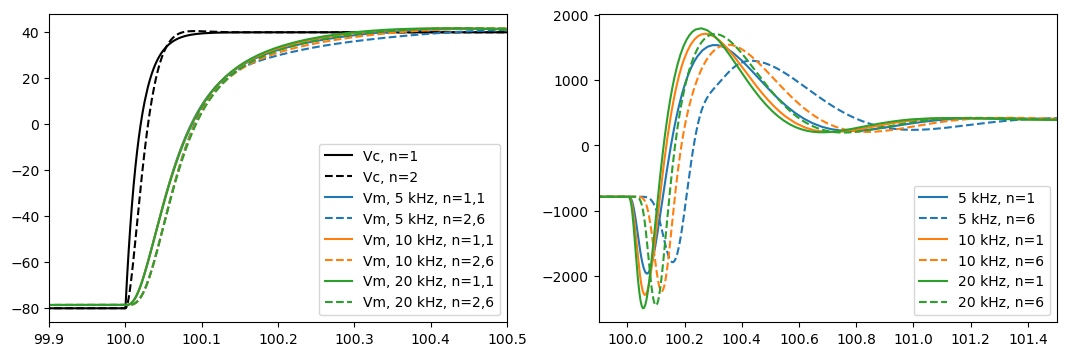

In [7]:
colors = matplotlib.colormaps['tab10'].colors
fig = plt.figure(figsize=(13, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_xlim(99.9, 100.5)
ax2.set_xlim(99.9, 101.5)

ax1.plot(d1.time(), d1['amp.Vc'], 'k', label='Vc, n=1')
ax1.plot(d2.time(), d2['amp.Vc2'], 'k--', label='Vc, n=2')

for i, f1 in enumerate([5, 10, 20]):
    s1.set_constant('amp.f1', f1)
    s2.set_constant('amp.f1', f1)
    s1.reset()
    s2.reset()
    d1 = s1.run(200)
    d2 = s2.run(200)
    ax1.plot(d1.time(), d1['amp.Vm'], color=colors[i], label=f'Vm, {f1} kHz, n=1,1')
    ax1.plot(d2.time(), d2['amp.Vm'], color=colors[i], ls='--', label=f'Vm, {f1} kHz, n=2,6')
    ax2.plot(d1.time(), d1['amp.I_obs'], color=colors[i], label=f'{f1} kHz, n=1')
    ax2.plot(d2.time(), d2['amp.I_obs'], color=colors[i], ls='--', label=f'{f1} kHz, n=6')
ax1.legend()
ax2.legend()

plt.show()

## The effect of the stimulus filter

Filter1 and filter2 set to 30kHz and 100kHz - so pretty much off.
Stimulus filter varied.

In [8]:
def reset(s):
    s.reset()
    s.set_constant('amp.f1', 10)
    s.set_constant('amp.f2', 10)
    s.set_constant('amp.tr', 0.04)

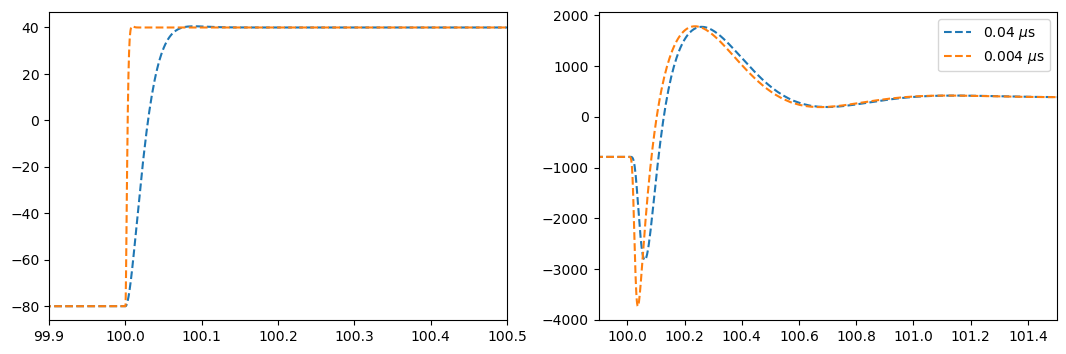

In [9]:
reset(s1)
reset(s2)
s1.set_constant('amp.f1', 30)
s2.set_constant('amp.f1', 30)
s1.set_constant('amp.f2', 100)
s2.set_constant('amp.f2', 100)

fig = plt.figure(figsize=(13, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_xlim(99.9, 100.5)
ax2.set_xlim(99.9, 101.5)

for i, tr in enumerate([0.04, 0.004]):
    #s1.set_constant('amp.tr', tr)
    s2.set_constant('amp.tr', tr)
    #s1.reset()
    s2.reset()
    #d1 = s1.run(200)
    d2 = s2.run(200)

    c = color=colors[i]
    #ax1.plot(d1.time(), d1['amp.Vc'],  color=c, label='Vc, n=1')
    ax1.plot(d2.time(), d2['amp.Vc2'], color=c, ls='--')
    #ax2.plot(d1.time(), d1['amp.I_obs'], color=c, label=f'{f1} kHz, n=1')
    ax2.plot(d2.time(), d2['amp.I_obs'], color=c, ls='--', label=f'{tr} $\\mu$s')
#ax1.legend()
ax2.legend()

plt.show()

# OPEN QUESTIONS

- Is the "Rs comp resistance" _lag_ (or `r_series_tau`) the same as "the speed of the summing amp"? Do we need a speed of a summing amp? Are Rs comp and Rs pred both affected?
  - Note: In Chon's version, tau_z ends up representing the effects of RfCf, F1, and F2 _on the output_. This is why he describes it as depending on the filter settings. It is a 1-pole representation of the filter cascade.
  - If there is a "speed of the summing amp" then this would affect $V_c$ and hence $I_obs$ _even when Rs comp is switched off_
- Is r_series_tau a parameter related to a filter?
  - Filter1 is set automatically based on "r_series_tau". So _is_ filter1 the source of this tau? ? No, because 10us and 100us both use Bessel 10kHz.
  - In Axon devices, there is a "lag" parameter in us which is described as being 1/2pif with f the frequency of a 1-pole filter used in the Rs comp feedback loop.
  - Is there an additional 1-pole filter after filter1 used only in the Rs feedback loop? And if so, is tau simply 1/2pif for this filter? Or have they done some sum to make filter1+filter3 (let's call it that)
  
Things to test:
- With prediction switched off, and compensation at e.g. 1%. Change the r_series_tau and see if a voltage step is affected. If so the summing amp version is corrrect
- 



To find out:

- disable filter2
- set the speed of acquisition to the highest it can be (5us)
- try to minimise noise


zzzz
- Set Rs comp to 0, 20%, 40%, 60%, 80%
- Set prediction to 0, then 0-20, then 0-20-40 etc
- Repeat for each setting of the speed
- If possible, leave filter1 at the highest setting instead of using the auto value

In [3]:
import numpy as np
print('2us  ', 1 / (2 * np.pi * 30e3))
print('5us  ', 1 / (2 * np.pi * 30e3) * 1e6, 'us')
print('10us ', 1 / (2 * np.pi * 10e3))
print('100us', 1 / (2 * np.pi * 10e3) * 1e6, 'us')



2us   5.305164769729844e-06
5us   5.305164769729844 us
10us  1.5915494309189534e-05
100us 15.915494309189533 us


In [68]:
m1 = myokit.parse_model('''
[[model]]
amp.Vm = -80
amp.Vp = -80
amp.Vo = -80
amp.Ve = -80
amp.Vr = -80
amp.Vf11 = -80
amp.Vf12 = -80
amp.Vf13 = -80
amp.Vf14 = -80
amp.Vf15 = -80
amp.Vf16 = -80
amp.Vc1 = -80
amp.Vc2 = -80

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
I = 1000 [nS] * Vm
    in [pA]
alpha = 0.7
beta = 0.7
Rs = 5.457e-3 [GOhm] in [GOhm]
Rs_est = 5.457e-3 [GOhm] in [GOhm]
Cm = 21.675 [pF] in [pF]
Cm_est = 21.675 [pF] in [pF]
Cp = 5.78 [pF] in [pF]
Cp_est = 5.78 [pF] in [pF]
Rf = 0.495 [GOhm] in [GOhm]
Cf = 0.16 [pF] in [pF]
tau_amp = 20e-6 [ms] in [ms]
tau_sum = 10e-3 [ms] in [ms]

# Voltage clamp and compensations
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vp) = ((Vo - Vp) / Rf - (Vp - Vm) / Rs +
            Cf * dot(Vo) + Cm_est * dot(Ve) + Cp_est * dot(Vr)
          ) / (Cp + Cf)
    in [mV]
dot(Vo) = (Vr - Vp) / tau_amp
    in [mV]
dot(Ve) = (Vc2 - Ve) / ((1 - beta) * Rs_est * Cm_est)
    in [mV]
dot(Vr) = (Vc2 + alpha * Rs_est / Rf * Vf16 + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum
    in [mV]

# Filter 1
f1 = 10 [kHz] in [kHz]
a1 = 2.7034 / (2 * 3.14159 * f1)
    in [ms]
dot(Vf11) = 26.514 / a1^2 * (Vo - Vr - Vf12) - 5.0319 / a1 * Vf11
    in [mV/ms]
dot(Vf12) = Vf11
    in [mV]
dot(Vf13) = 20.853 / a1^2 * (Vf12 - Vf14) - 7.4714 / a1 * Vf13
    in [mV/ms]
dot(Vf14) = Vf13
    in [mV]
dot(Vf15) = 18.801 / a1^2 * (Vf14 - Vf16) - 8.4967 / a1 * Vf15
    in [mV/ms]
dot(Vf16) = Vf15
    desc: The 6-pole filtered output
    in [mV]

# Input filter
tr = 0.04 [ms] in [ms]
a3 = 1.3616 * tr / log(9)
    in [ms]
Vs = engine.pace * 1 [mV]
    in [mV]
dot(Vc1) = 3 * ((Vs - Vc2) / a3^2 - Vc1 / a3)
    in [mV/ms]
dot(Vc2) = Vc1
    desc: The 2-pole filtered stimulus
    in [mV]

# Output current (without filter2)
I_obs = Vf16 / Rf
    in [pA]
''')
m1.check_units(myokit.UNIT_STRICT)

s1 = myokit.Simulation(m1, p)
s1.set_tolerance(1e-8)
s1.pre(50)

print('Tau amp', m1.get('amp.Rf').eval() * m1.get('amp.Cf').eval())

Tau amp 0.0792


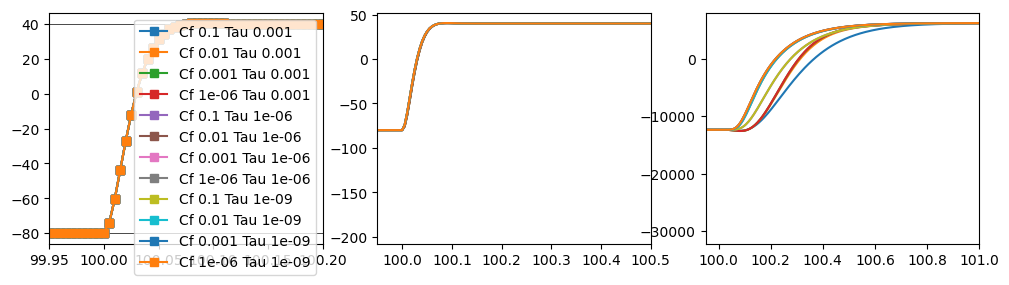

In [85]:
fig = plt.figure(figsize=(12, 3))

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_xlim(99.95, 100.5)

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_xlim(99.95, 101)

#for tau in [2e-3, 5e-3, 0.01, 0.1]:
for tau in [1e-3, 1e-6, 1e-9]:
    for cf in [1e-1, 1e-2, 1e-3, 1e-6]:
        s1.reset()
        #s1.set_constant('amp.tau_sum', tau)
        s1.set_constant('amp.alpha', 0.0)
        s1.set_constant('amp.beta', 0.0)
        s1.set_constant('amp.Cf', cf) #0.16)
        s1.set_constant('amp.tau_amp', tau)
        s1.set_constant('amp.tau_sum', tau)

        #Cf = 0.16 [pF] in [pF]
        #tau_amp = 20e-6 [ms] in [ms]
        #tau_sum = 10e-3 [ms] in [ms]
    
        d1 = s1.run(200, log_interval=0.005)
        ax1.plot(d1.time(), d1['amp.Vc2'], 's-', label=f'Cf {cf} Tau {tau}')
        ax2.plot(d1.time(), d1['amp.Vr'])
        ax3.plot(d1.time(), d1['amp.I_obs'])

ax1.legend()
plt.show()

<img src="resources/patch-comp-8-filters.png" style="margin:auto" />

- Does tau affect the stimulus?
  - Can't see on Vout --> Is before then. But if it isn't then we'll see changes with different tau
  - 

## Filtering the output

Patch-clamp amplifiers have several options to filter the data as they record it.
In the HEKA EPC-9 and EPC-10, which are based on the Sigworth design discussed here, there are two built-in analog filters, one of which is always on [Sigworth 1995b](https://doi.org/10.1016/0165-0270(94)00128-4).

Instead of working out the transfer function etc., we'll simulate the application of the analog filter using a digital filter from SciPy.
I'm not 100% sure this is the best way to do it.
Some discussion can be found [on stack exchange](https://dsp.stackexchange.com/questions/8319).

From the manuals, we can see that the EPC-9 uses a 3d order Bessel filter set to 10kHz in most situations, while the EPC-10 uses a 6th order one.

Let's see how this might affect a sodium current, i.e. a Beeler-Reuter sodium current when stepping from -80 to -20mV.

In [10]:
import myokit
import numpy as np
import matplotlib.pyplot as plt

In [11]:
m = myokit.parse_model('''
[[model]]
ina.m = 0.01
ina.h = 0.99
ina.j = 0.98

[engine]
time = 0 [ms]
    in [ms]
    bind time
    
[membrane]
V = 0 [mV]
    in [mV]
    bind pace

[ina]
use membrane.V as V
gNaBar = 4 [mS/cm^2]
    in [mS/cm^2]
gNaC = 0.003 [mS/cm^2]
    in [mS/cm^2]
ENa = 50 [mV]
    in [mV]
INa = (gNaBar * m^3 * h * j + gNaC) * (V - ENa)
    in [uA/cm^2]
    desc: The excitatory inward sodium current
dot(m) =  alpha * (1 - m) - beta * m
    alpha = 1 [1/mV/ms] * (V + 47 [mV]) / (1 - exp(-0.1 [1/mV] * (V + 47 [mV])))
        in [1/ms]
    beta  = 40 [1/ms] * exp(-0.056 [1/mV] * (V + 72 [mV]))
        in [1/ms]
dot(h) =  alpha * (1 - h) - beta * h
    alpha = 0.126 [1/ms] * exp(-0.25 [1/mV] * (V + 77 [mV]))
        in [1/ms]
    beta  = 1.7 [1/ms] / (1 + exp(-0.082 [1/mV] * (V + 22.5 [mV])))
        in [1/ms]
dot(j) =  alpha * (1 - j) - beta * j
    alpha = 0.055 [1/ms] * exp(-0.25 [1/mV] * (V + 78 [mV])) / (1 + exp(-0.2 [1/mV] * (V + 78 [mV])))
        in [1/ms]
    beta  = 0.3 [1/ms] / (1 + exp(-0.1 [1/mV] * (V + 32 [mV])))
        in [1/ms]
''')
m.check_units(myokit.UNIT_STRICT)

In [12]:
p = myokit.Protocol()
p.schedule(start=0, level=-80, duration=100)
p.schedule(start=100, level=-20, duration=20)

In [13]:
s = myokit.Simulation(m, p)
s.run(99)
d = s.run(6, log_interval=1e-4)
d = d.npview()

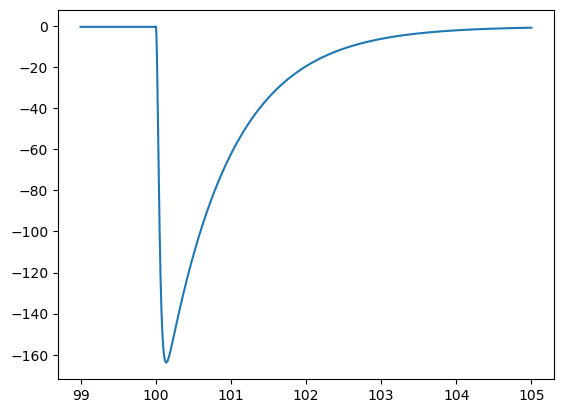

In [14]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(d.time(), d['ina.INa'])
plt.show()

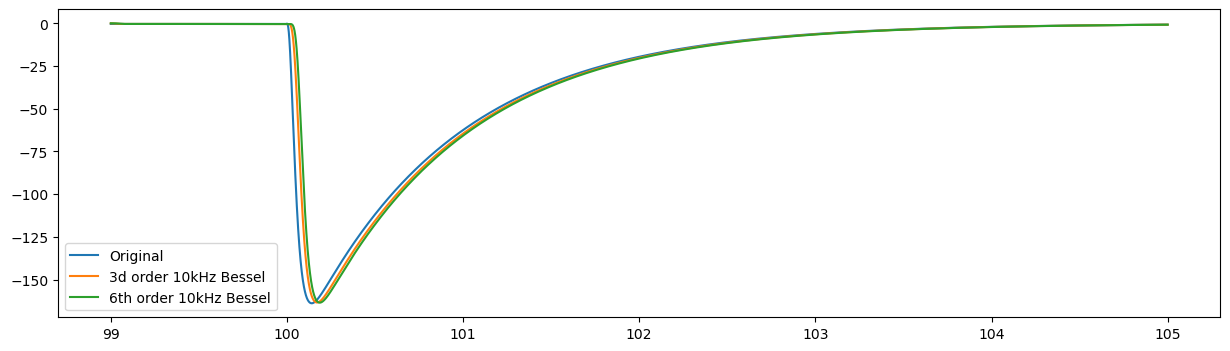

In [15]:
import scipy.signal

t = d.time()
dt = np.mean(t[1:] - t[:-1])   # In ms
fs = 1 / dt    # Sampling frequency, in kHz
fc = 10        # Cut-off frequency, in kHz

def low_pass(data, fc, fs, n=3):
    """ Apply a Bessel low-pass filter with cut-off fc (in Hz). """
    b, a = scipy.signal.bessel(n, fc / (fs / 2), btype='lowpass', norm='mag')
    return scipy.signal.lfilter(b, a, data)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, d['ina.INa'], label='Original')
ax.plot(t, low_pass(d['ina.INa'], fc, fs, 3), label='3d order 10kHz Bessel')
ax.plot(t, low_pass(d['ina.INa'], fc, fs, 6), label='6th order 10kHz Bessel')
ax.legend()
plt.show()

For this fast current, the filtering does seem to have a notable effect.
It's also worth noting that, in the published EPC-9 design, the $R_s$ compensation uses a signal that has been passed through this filter.

For now, we will not include the filter in our model.
See [Kuo & Bean (1994)](https://doi.org/10.1016/0896-6273(94)90335-2) for a real-life mention of the filter's effect on very fast INa properties.